# Show data about public Xatu data contributors
See .env.example to set the environment variables.

In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn > /dev/null 2>&1

In [2]:
import dotenv
import os
from datetime import datetime

dotenv.load_dotenv()

# Load and display config
start_slot = os.getenv('START_SLOT')
if not start_slot:
    start_slot = 0

end_slot = os.getenv('END_SLOT')

network = os.getenv('NETWORK')

print(f"start_slot: {start_slot}")
print(f"end_slot: {end_slot}")

beacon_node_url = os.getenv('BEACON_NODE_URL')
if not beacon_node_url:
    raise ValueError("BEACON_NODE_URL environment variable is required")



start_slot: 0
end_slot: 


In [7]:
import requests
from datetime import datetime, timezone

# Get genesis config from beacon node
spec_resp = requests.get(f"{beacon_node_url}/eth/v1/config/spec")
if not spec_resp.ok:
    raise Exception(f"Failed to get genesis config: {spec_resp.status_code} {spec_resp.text}")

genesis_resp = requests.get(f"{beacon_node_url}/eth/v1/beacon/genesis")
if not genesis_resp.ok:
    raise Exception(f"Failed to get genesis config: {genesis_resp.status_code} {genesis_resp.text}")

genesis_config = genesis_resp.json()["data"]
print("Genesis config loaded")

spec_config = spec_resp.json()["data"]
print("Spec config loaded")

# Get genesis time from config
genesis_time = int(genesis_config["genesis_time"])

# Calculate slot times
seconds_per_slot = int(spec_config["SECONDS_PER_SLOT"]) 

start_slot_time = genesis_time + (int(start_slot) * seconds_per_slot)
start_date = datetime.fromtimestamp(start_slot_time, tz=timezone.utc).isoformat()

if end_slot:
    end_slot_time = genesis_time + (int(end_slot) * seconds_per_slot)
    end_date = datetime.fromtimestamp(end_slot_time, tz=timezone.utc).isoformat()
else:
    # If no end slot specified, use current time
    end_date = datetime.now(timezone.utc).isoformat()

print(f"start_date: {start_date}")
print(f"end_date: {end_date}")


Genesis config loaded
Spec config loaded
start_date: 2024-11-22T15:01:00+00:00
end_date: 2024-11-25T04:18:05.472098+00:00


In [8]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine

engine = create_engine(db_url)

connection = engine.connect()

In [17]:
from sqlalchemy import text

query = text("""
    SELECT
        toDate(slot_start_date_time) as time,
        meta_network_name,
        uniqExact(meta_client_name) AS total
    FROM beacon_api_eth_v1_events_block FINAL
    WHERE
        slot_start_date_time BETWEEN toDateTime(substring(:start_date, 1, 19), 'UTC') AND toDateTime(substring(:end_date, 1, 19), 'UTC')
        AND meta_network_name = :network
    GROUP BY time, meta_network_name
""")

result = connection.execute(query, {"start_date": start_date, "end_date": end_date, "network": network})
users = result.fetchall()

if len(users) == 0:
    raise ValueError("No users found for the given time range")

print(f"Found {len(users)} users for the given time range")

print(users)


Found 4 users for the given time range
[(datetime.date(2024, 11, 24), 'nft-devnet-0', 18), (datetime.date(2024, 11, 23), 'nft-devnet-0', 18), (datetime.date(2024, 11, 25), 'nft-devnet-0', 11), (datetime.date(2024, 11, 22), 'nft-devnet-0', 21)]


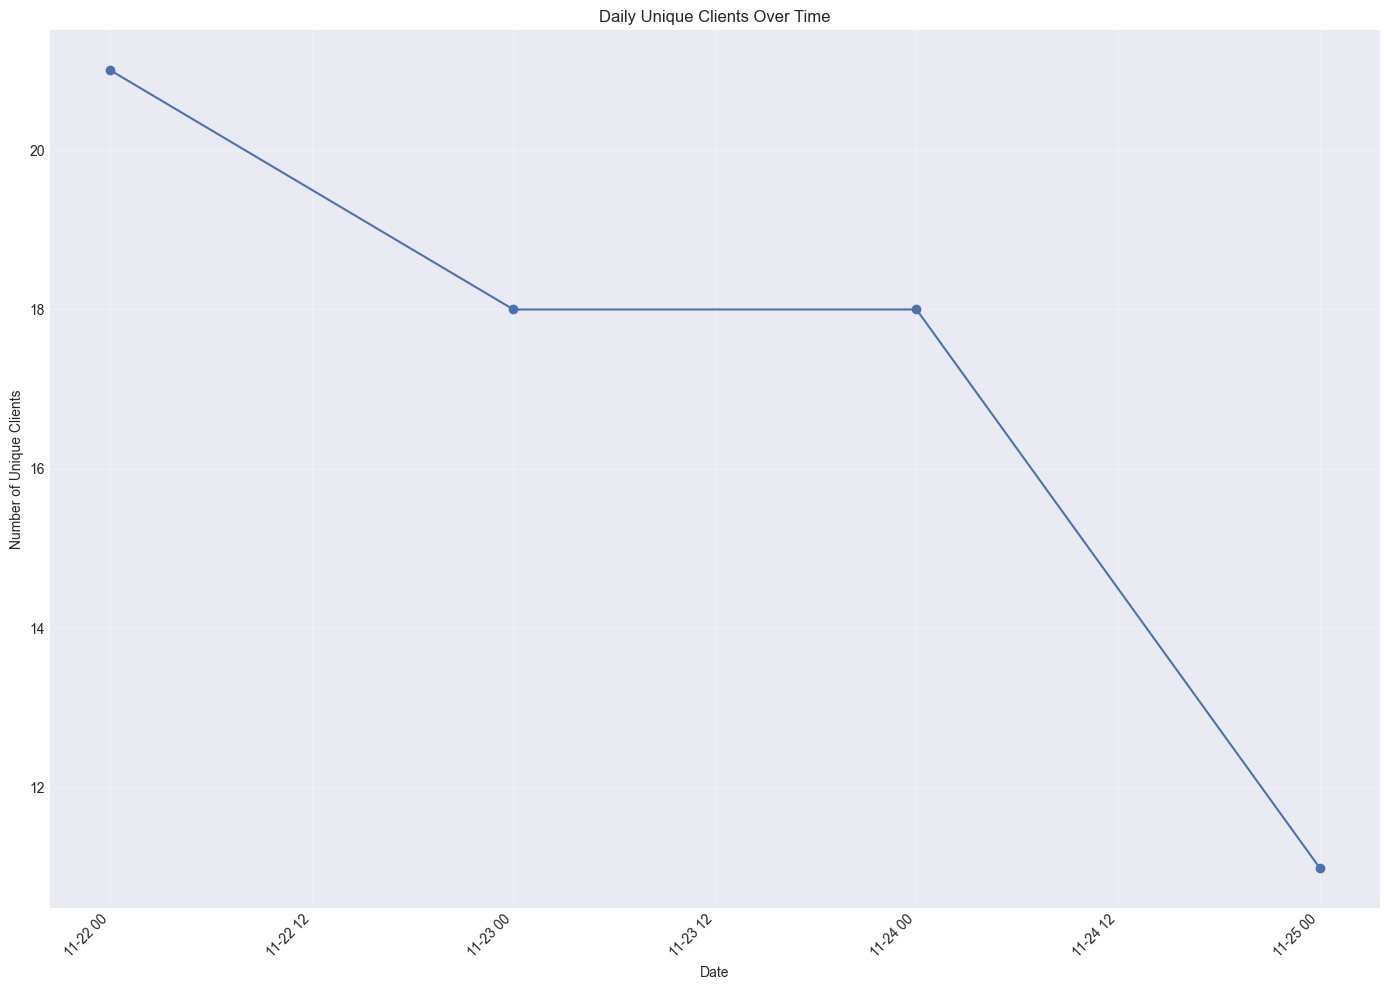

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame(users, columns=['time', 'network', 'total'])
df['time'] = pd.to_datetime(df['time'])

# Sort data by time
df = df.sort_values('time')

# Create figure
plt.figure(figsize=(14, 10))

# Plot data
plt.plot(df['time'], df['total'], marker='o')

# Customize plot
plt.title('Daily Unique Clients Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Unique Clients')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

plt.show()


In [65]:
from sqlalchemy import text

query = text("""
    WITH slots_with_blobs AS (
        SELECT DISTINCT
            slot,
            count(distinct blob_index) as blobs_per_slot,
            epoch
        FROM beacon_api_eth_v1_events_blob_sidecar FINAL
        WHERE
            slot_start_date_time BETWEEN parseDateTimeBestEffort(:start_date) AND parseDateTimeBestEffort(:end_date)
            AND meta_network_name = :network
        GROUP BY slot, epoch
    ),
    all_slots AS (
        SELECT DISTINCT slot, epoch
        FROM beacon_api_eth_v1_events_block FINAL
        WHERE 
            slot_start_date_time BETWEEN parseDateTimeBestEffort(:start_date) AND parseDateTimeBestEffort(:end_date)
            AND meta_network_name = :network
    )
    SELECT
        epoch,
        avg(COALESCE(blobs_per_slot, 0)) as avg_blobs,
        min(COALESCE(blobs_per_slot, 0)) as min_blobs,
        max(COALESCE(blobs_per_slot, 0)) as max_blobs,
        quantile(0.05)(COALESCE(blobs_per_slot, 0)) as p05_blobs,
        quantile(0.50)(COALESCE(blobs_per_slot, 0)) as p50_blobs,
        quantile(0.95)(COALESCE(blobs_per_slot, 0)) as p95_blobs
    FROM all_slots
    LEFT JOIN slots_with_blobs USING (slot, epoch)
    GROUP BY epoch
    ORDER BY epoch
""")

result = connection.execute(query, {
    "start_date": start_date,
    "end_date": end_date, 
    "network": network
})
slots = result.fetchall()


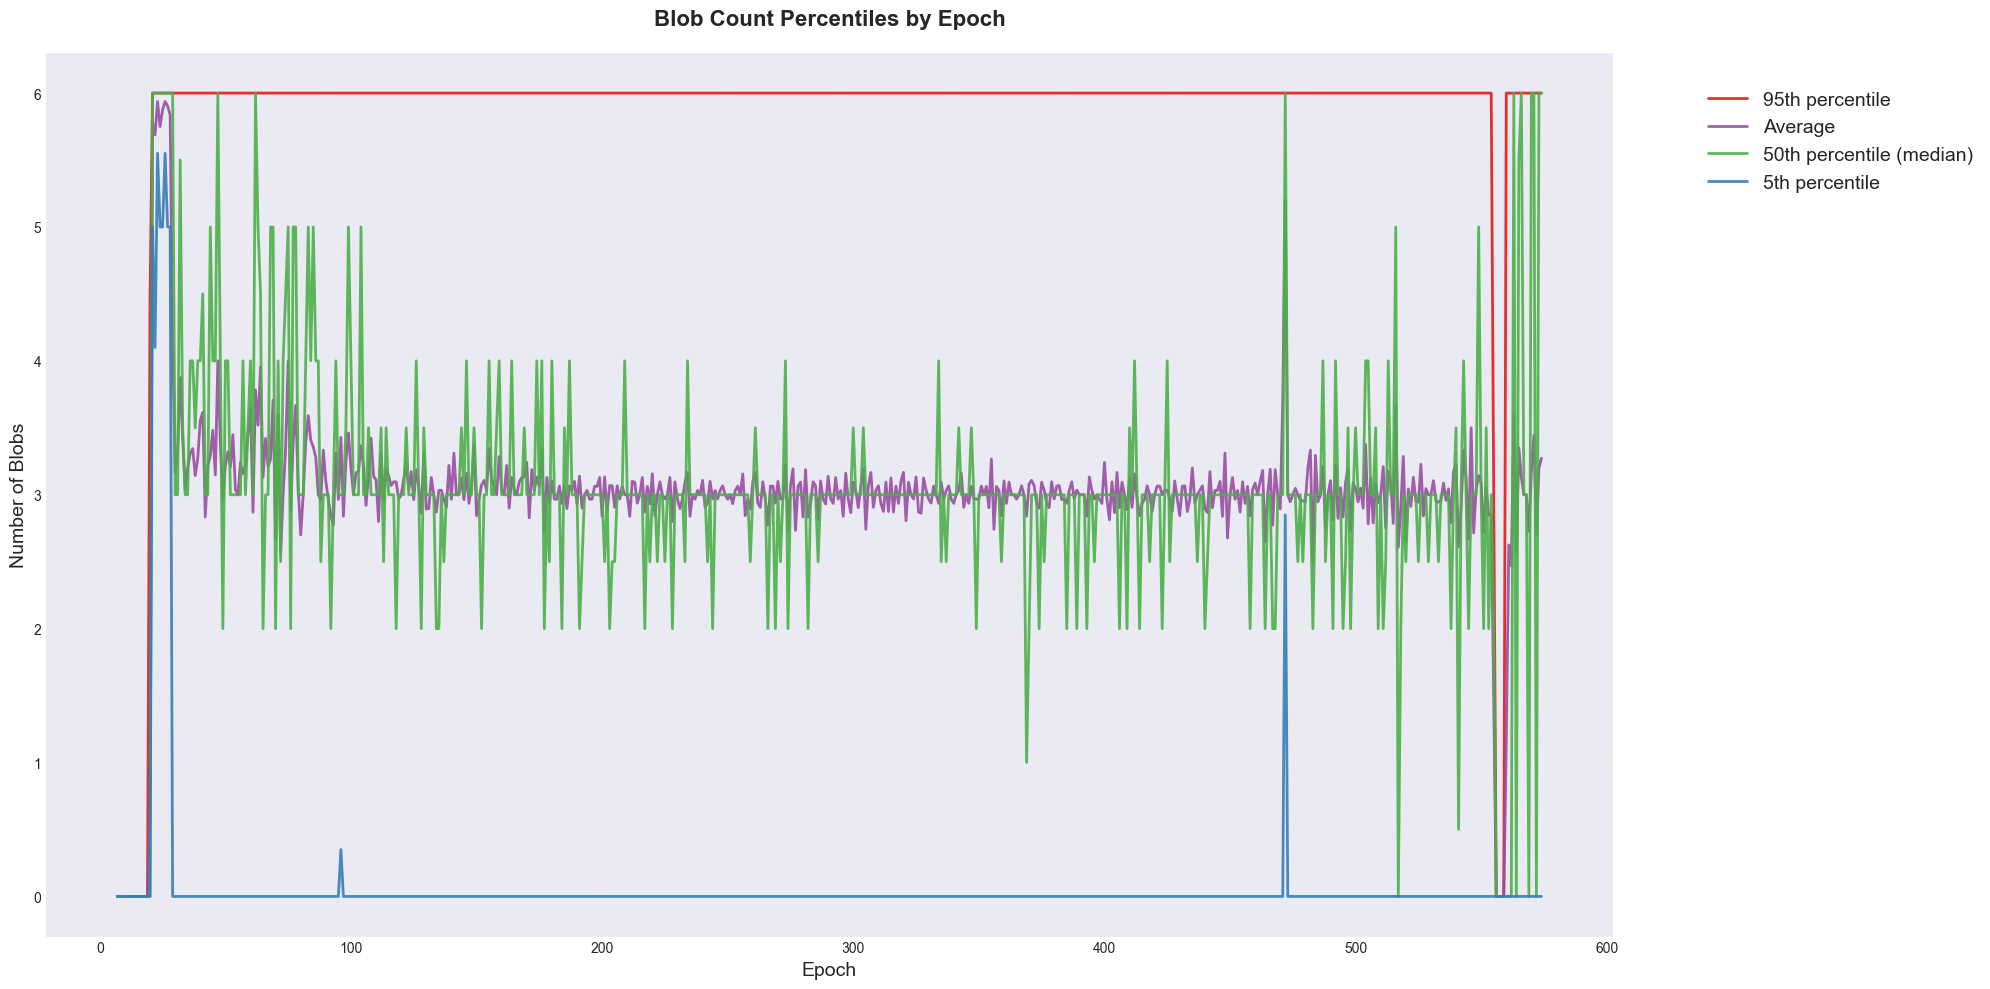

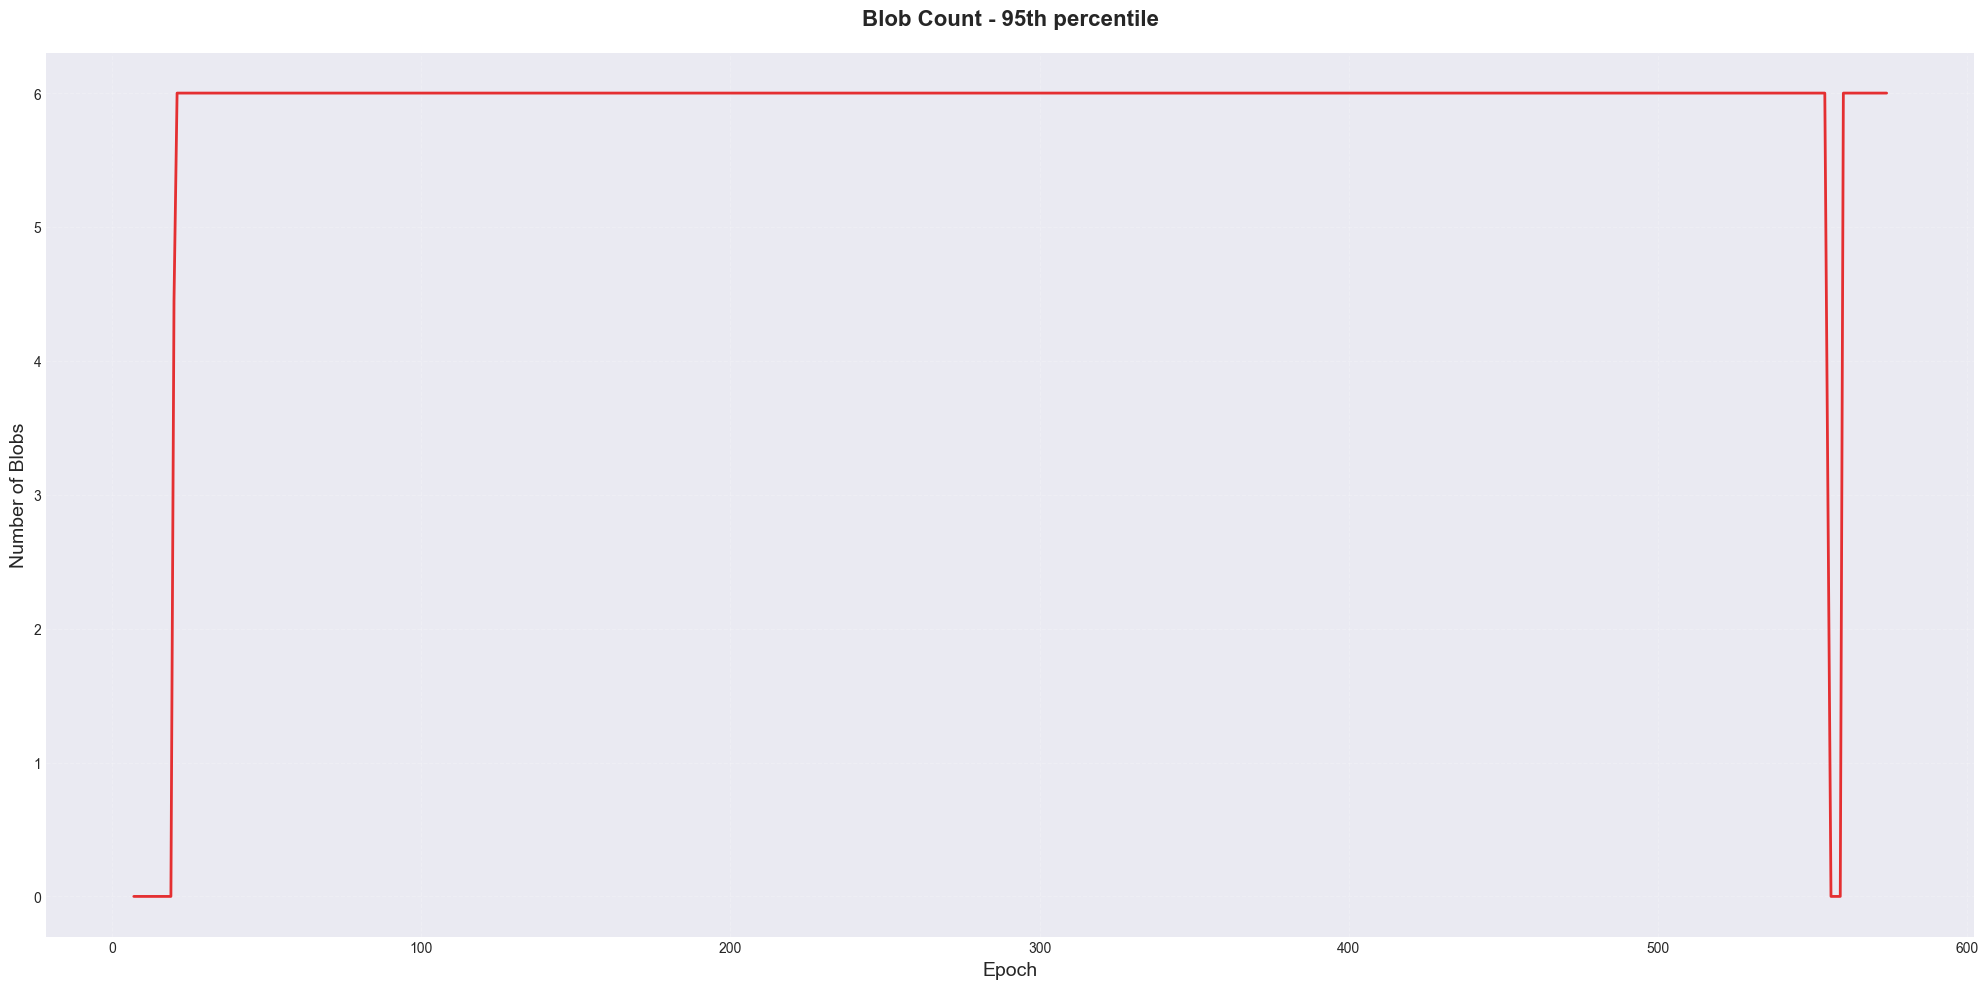

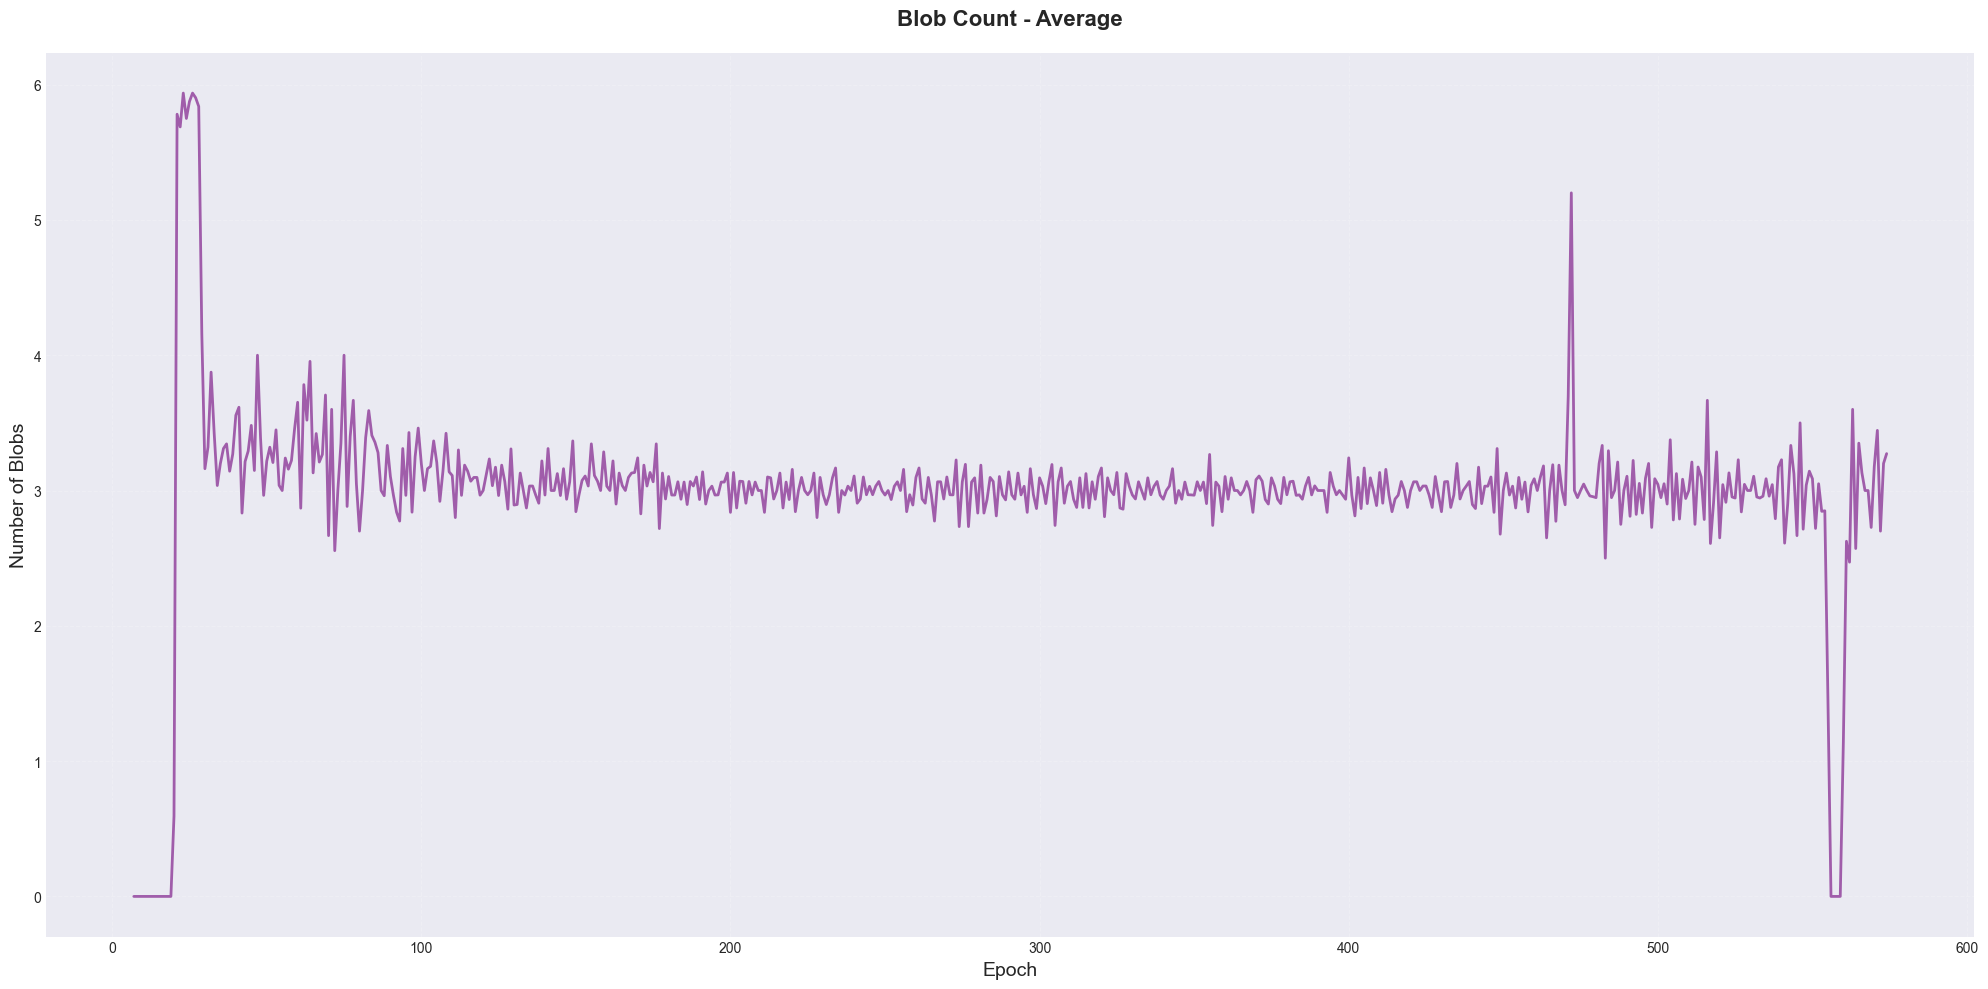

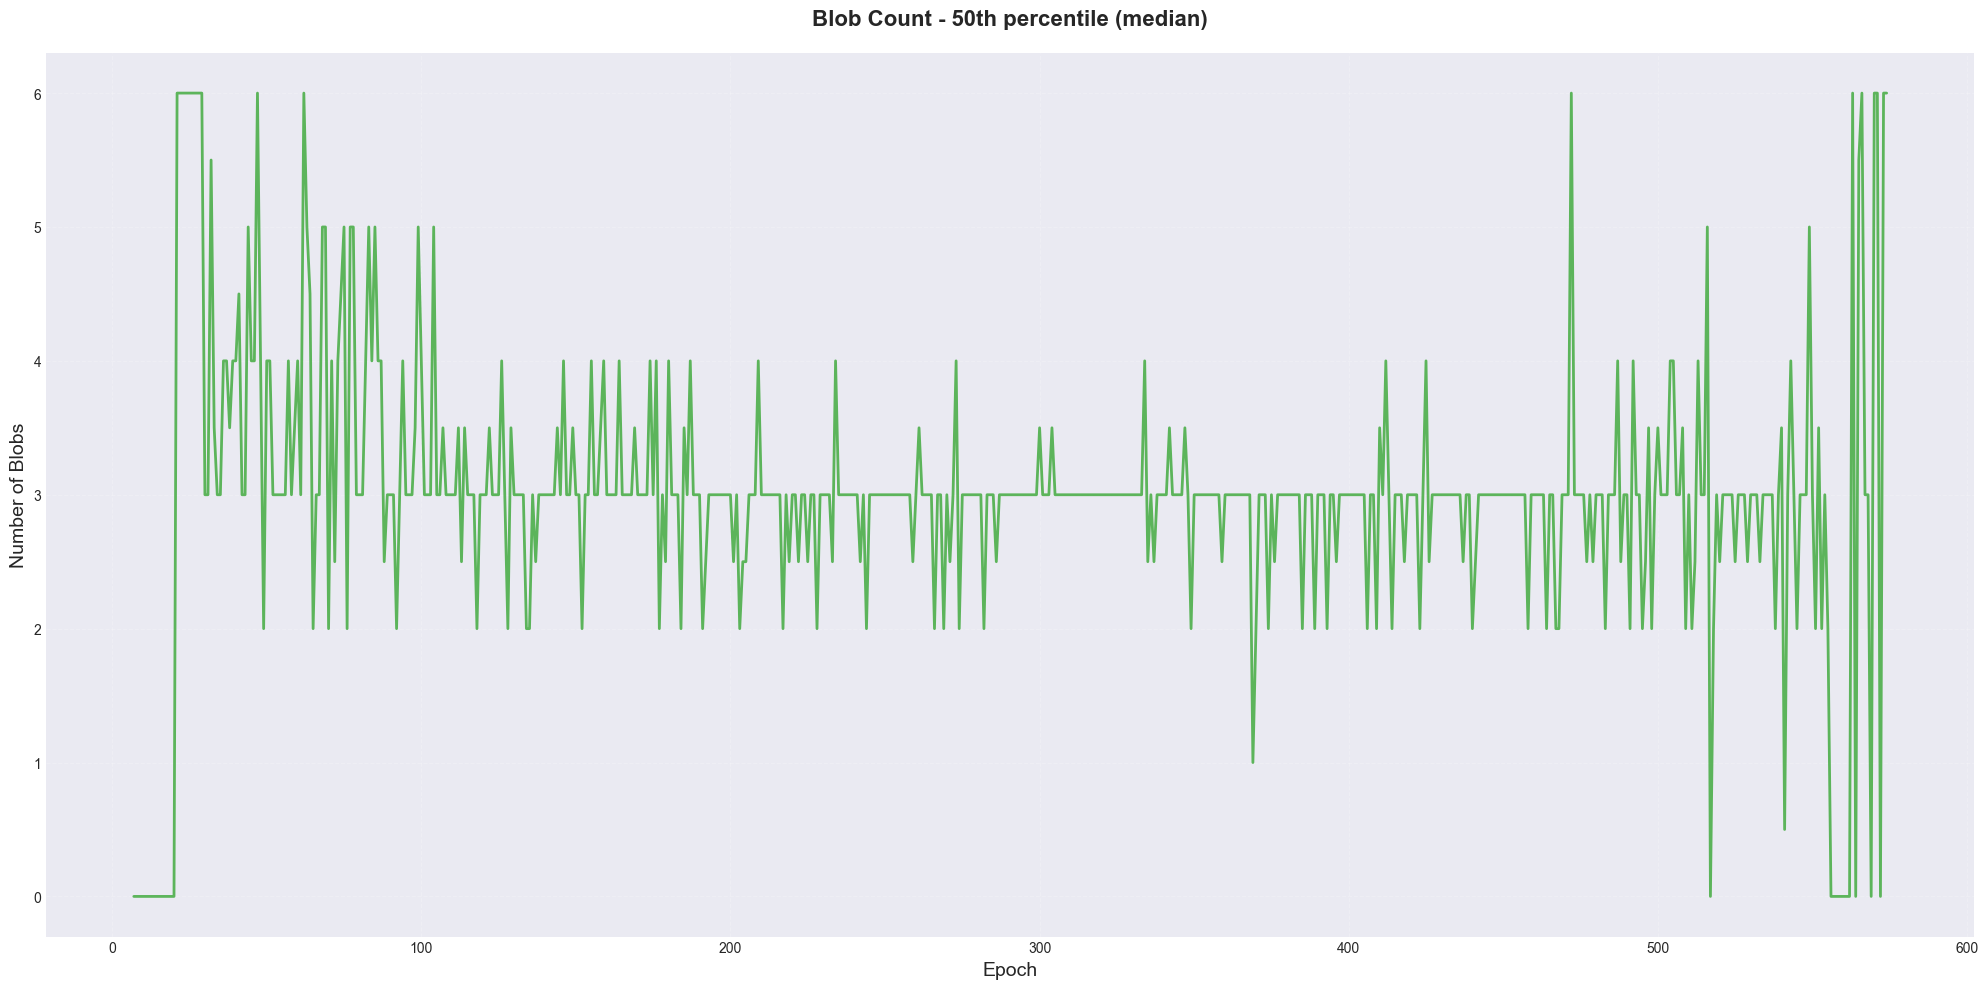

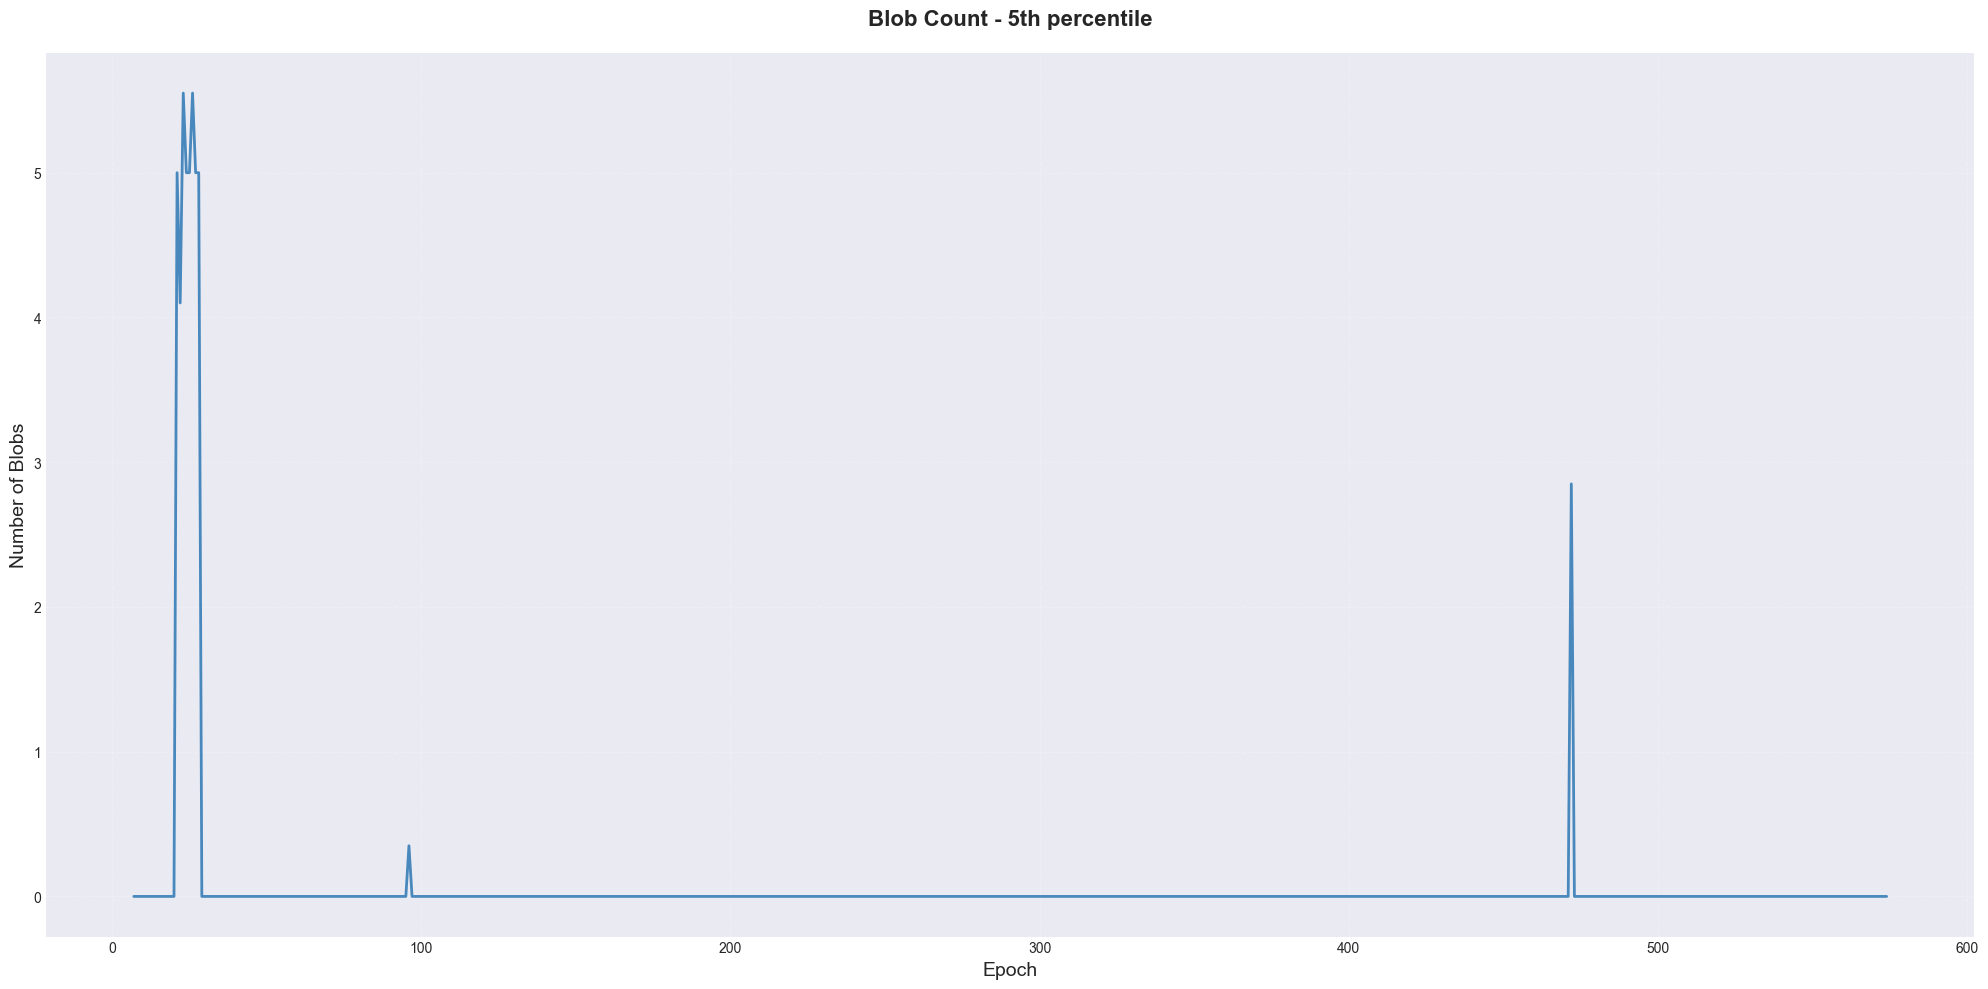

In [66]:
# Convert query results to DataFrame
df = pd.DataFrame(slots, columns=['epoch', 'avg_blobs', 'min_blobs', 'max_blobs', 'p05_blobs', 'p50_blobs', 'p95_blobs'])

# Combined plot
plt.figure(figsize=(20, 10))

colors = {
    'p95_blobs': '#e41a1c',
    'avg_blobs': '#984ea3', 
    'p50_blobs': '#4daf4a',
    'p05_blobs': '#377eb8'
}

labels = {
    'p95_blobs': '95th percentile',
    'avg_blobs': 'Average',
    'p50_blobs': '50th percentile (median)', 
    'p05_blobs': '5th percentile'
}

for col in ['p95_blobs', 'avg_blobs', 'p50_blobs', 'p05_blobs']:
    plt.plot(df['epoch'], df[col], color=colors[col], linewidth=2, label=labels[col], alpha=0.9)

plt.title('Blob Count Percentiles by Epoch', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Number of Blobs', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 0.9), loc='center left', framealpha=0.9, fontsize=14)
plt.grid(True, alpha=0.2, linestyle='--')
plt.tight_layout()
plt.show()

# Individual plots
for col in ['p95_blobs', 'avg_blobs', 'p50_blobs', 'p05_blobs']:
    plt.figure(figsize=(20, 10))
    plt.plot(df['epoch'], df[col], color=colors[col], linewidth=2, alpha=0.9)
    plt.title(f'Blob Count - {labels[col]}', pad=20, fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Number of Blobs', fontsize=14)
    plt.grid(True, alpha=0.2, linestyle='--')
    plt.tight_layout()
    plt.show()


In [67]:
# Query for slot/blob count distribution
query = text("""
    WITH slots_with_blobs AS (
        SELECT DISTINCT
            slot,
            count(distinct blob_index) as blobs_per_slot
        FROM beacon_api_eth_v1_events_blob_sidecar FINAL 
        WHERE
            slot_start_date_time BETWEEN parseDateTimeBestEffort(:start_date) AND parseDateTimeBestEffort(:end_date)
            AND meta_network_name = :network
        GROUP BY slot
    ),
    all_slots AS (
        SELECT DISTINCT slot 
        FROM beacon_api_eth_v1_events_block FINAL
        WHERE 
            slot_start_date_time BETWEEN parseDateTimeBestEffort(:start_date) AND parseDateTimeBestEffort(:end_date)
            AND meta_network_name = :network
    )
    SELECT
        COALESCE(blobs_per_slot, 0) as blobs_per_slot,
        count(*) as slot_count
    FROM all_slots
    LEFT JOIN slots_with_blobs USING (slot)
    GROUP BY blobs_per_slot
    ORDER BY blobs_per_slot
""")

result = connection.execute(query, {
    "start_date": start_date,
    "end_date": end_date,
    "network": network
})
blob_counts = result.fetchall()

print("Slots grouped by blob count:")
print(f"{'Blobs per slot':>15} | {'Number of slots':>15}")
print("-" * 33)
for row in blob_counts:
    print(f"{row[0]:>15} | {row[1]:>15}")


Slots grouped by blob count:
 Blobs per slot | Number of slots
---------------------------------
              0 |            5119
              1 |             824
              2 |            1205
              3 |            1710
              4 |             610
              5 |            1295
              6 |            4957
